In [2]:
import scanpy as sc
import anndata
import numpy as np
import os
import glob
import pandas as pd
from tqdm import tqdm
import torch

In [6]:
# Function to load cell obs data from backed h5ad files
def load_cell_obs(plate_num):
    plate_path = f"/home/ubuntu/data/raw/plate{plate_num}_filt_Vevo_Tahoe100M_WServicesFrom_ParseGigalab.h5ad"
    # Load only the obs data, using backed mode to save memory
    adata = sc.read_h5ad(plate_path, backed='r')
    cell_obs = adata.obs.copy()
    cell_names = adata.obs_names.tolist()
    return cell_names, cell_obs

# Function to load embeddings from numpy files
def load_embeddings(plate_num):
    embedding_path = f'plate{plate_num}_embeddings.npy'
    return np.load(embedding_path)

# Load all cell obs data and embeddings
all_cell_names = []
all_cell_obs = []
all_embeddings = []

# Process each plate (1-14)
for i in tqdm(range(1, 15)):
    cell_names, cell_obs = load_cell_obs(i)
    embeddings = load_embeddings(i)
    
    # Ensure the number of cells matches the number of embeddings
    assert len(cell_names) == embeddings.shape[0], f"Mismatch in plate {i}: {len(cell_names)} cells vs {embeddings.shape[0]} embeddings"
    
    all_cell_names.extend(cell_names)
    all_cell_obs.append(cell_obs)
    all_embeddings.append(embeddings)

# Combine all embeddings into a single array
combined_embeddings = np.vstack(all_embeddings)

# Combine all cell observations
combined_obs = pd.concat(all_cell_obs)

# Create an AnnData object with the combined embeddings
combined_ad = anndata.AnnData(
    X=combined_embeddings,
    obs=combined_obs
)

print(f"Created combined embeddings AnnData with {combined_ad.shape[0]} cells and {combined_ad.shape[1]} latent dimensions")


100%|██████████| 14/14 [03:59<00:00, 17.12s/it]


Created combined embeddings AnnData with 100648790 cells and 50 latent dimensions


In [62]:
combined_ad.write_h5ad("/home/ubuntu/data/ldvae_embeddings.h5ad")

In [15]:
edist = pd.read_csv("/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/data/tahoe_largest_edist_per_drug_cell_line_combo.csv")

In [17]:
combined_ad[combined_ad.obs["drugname_drugconc"].isin(edist["drug_info"])]

View of AnnData object with n_obs × n_vars = 0 × 50
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate'

In [22]:
combined_ad_filt = combined_ad[combined_ad.obs["drugname_drugconc"].apply(lambda x: x.strip('[]')).isin(edist["drug_info"])]

In [ ]:
# Aggregate control data by cell line
agg_control = sc.get.aggregate(combined_ad[combined_ad.obs["drug"]=="DMSO_TF"], by=["cell_line"], func=["mean"])

# Aggregate drug data by cell line and drug
agg_drug = sc.get.aggregate(combined_ad_filt, by=["cell_line", "drugname_drugconc"], func=["mean"])

In [31]:
# Create a dictionary to map cell line to control embedding
control_dict = {}
for cell_line in agg_control.obs_names:
    control_dict[cell_line] = agg_control[agg_control.obs_names == cell_line].layers['mean']

# Subtract control from drug for each cell line
drug_minus_control = agg_drug.layers['mean'].copy()
for i, (cell_line, _) in enumerate(zip(agg_drug.obs['cell_line'], agg_drug.obs['drugname_drugconc'])):
    # Find the control embedding for this cell line
    control_embedding = control_dict[cell_line]
    # Subtract control from drug
    drug_minus_control[i] = agg_drug.layers['mean'][i] - control_embedding

# Store the result in agg_drug
agg_drug.layers['drug_minus_control'] = drug_minus_control

In [55]:
drug_info_dict = dict(zip(edist["drug_info"], edist["drug_name"]))
agg_drug.obs["drug"] = agg_drug.obs["drugname_drugconc"].str.strip('[]').map(drug_info_dict)

In [63]:
# Create a DataFrame from the drug_minus_control layer
drug_minus_control_df = pd.DataFrame(
    agg_drug.layers["drug_minus_control"],
    columns=agg_drug.var_names,
    index=[f"{drug}_{cell_line}" for drug, cell_line in zip(agg_drug.obs["drug"], agg_drug.obs["cell_line"])]
)

# Create a DataFrame from the original mean layer (not minus control)
drug_df = pd.DataFrame(
    agg_drug.layers["mean"],
    columns=agg_drug.var_names,
    index=[f"{drug}_{cell_line}" for drug, cell_line in zip(agg_drug.obs["drug"], agg_drug.obs["cell_line"])]
)

drug_minus_control_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
(R)-Verapamil (hydrochloride)_CVCL_0023,-0.001189,-0.000930,-0.000356,-0.000772,0.001502,-0.001483,-0.000367,-0.000646,0.000231,0.000054,...,0.006757,-0.000348,-0.001312,0.002497,-0.001008,0.002215,-0.001303,-0.000437,-0.000089,0.000248
(R)-Verapamil (hydrochloride)_CVCL_0023,0.000509,-0.000314,-0.000501,0.001635,0.000267,0.001530,-0.000254,0.000078,-0.000296,-0.001709,...,-0.004816,0.002798,0.000306,-0.001051,0.000692,-0.001758,0.000546,0.000159,-0.000646,0.000613
(S)-Crizotinib_CVCL_0023,0.001051,0.000752,-0.000214,0.001631,-0.000497,0.001123,0.000194,0.000487,0.000163,-0.000990,...,-0.006705,0.001446,0.000833,-0.002262,0.001354,-0.001338,0.000030,0.000791,-0.000406,-0.000211
(S)-Crizotinib_CVCL_0023,0.000526,0.000310,-0.000936,-0.000181,-0.000224,-0.000014,0.000108,0.000219,0.000659,0.000945,...,-0.000703,0.000048,0.000071,-0.001652,0.000142,0.000163,-0.001194,0.000606,-0.000202,-0.000306
18β-Glycyrrhetinic acid_CVCL_0023,0.000612,-0.000744,-0.001400,0.001152,0.000551,0.001453,-0.000323,0.000138,-0.000099,-0.001424,...,-0.004113,0.002303,0.000311,-0.002108,0.000868,-0.000326,0.000812,0.000273,-0.000702,0.000532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vincristine_CVCL_C466,-0.000265,0.000069,0.000329,-0.000427,0.001357,-0.000266,-0.000137,-0.000241,-0.000239,0.000142,...,0.002062,-0.001047,-0.000634,-0.000247,-0.000422,0.000455,0.001756,-0.000591,0.000308,-0.000390
vincristine_CVCL_C466,0.001270,0.000834,0.001470,0.000604,-0.000746,0.001983,0.000357,0.000831,-0.001709,-0.000370,...,-0.009023,0.001240,0.000909,-0.000490,0.002720,-0.003731,0.001937,0.000975,0.000028,0.000928
γ-Oryzanol_CVCL_C466,0.000580,0.000537,-0.000426,0.000732,-0.001178,0.002092,-0.000386,0.000015,-0.000544,0.000309,...,-0.001335,-0.000095,0.000059,0.000016,0.000035,-0.001453,0.000773,0.000624,-0.000406,0.000121
γ-Oryzanol_CVCL_C466,0.000566,0.000652,-0.000245,0.000373,-0.001173,0.002531,-0.000274,0.000059,-0.000458,0.000660,...,-0.002606,0.000012,0.000019,-0.000053,-0.000455,-0.002143,0.001301,0.000597,-0.000375,0.000082


In [60]:
drug_minus_control_df.columns = [f"ldvae_minusctrl_{col}" for col in drug_minus_control_df.columns]
drug_df.columns = [f"ldvae_{col}" for col in drug_df.columns]

In [61]:
drug_minus_control_df.to_csv("/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/data_for_classifier/ldvae_embeddings.tsv", sep="\t", index=True)
drug_df.to_csv("/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/data_for_classifier/ldvae_raw_embeddings.tsv", sep="\t", index=True)

In [37]:
aggr_ldvae_ad.write_h5ad("/home/ubuntu/data/ldvae_cellline_drug_aggr.h5ad")

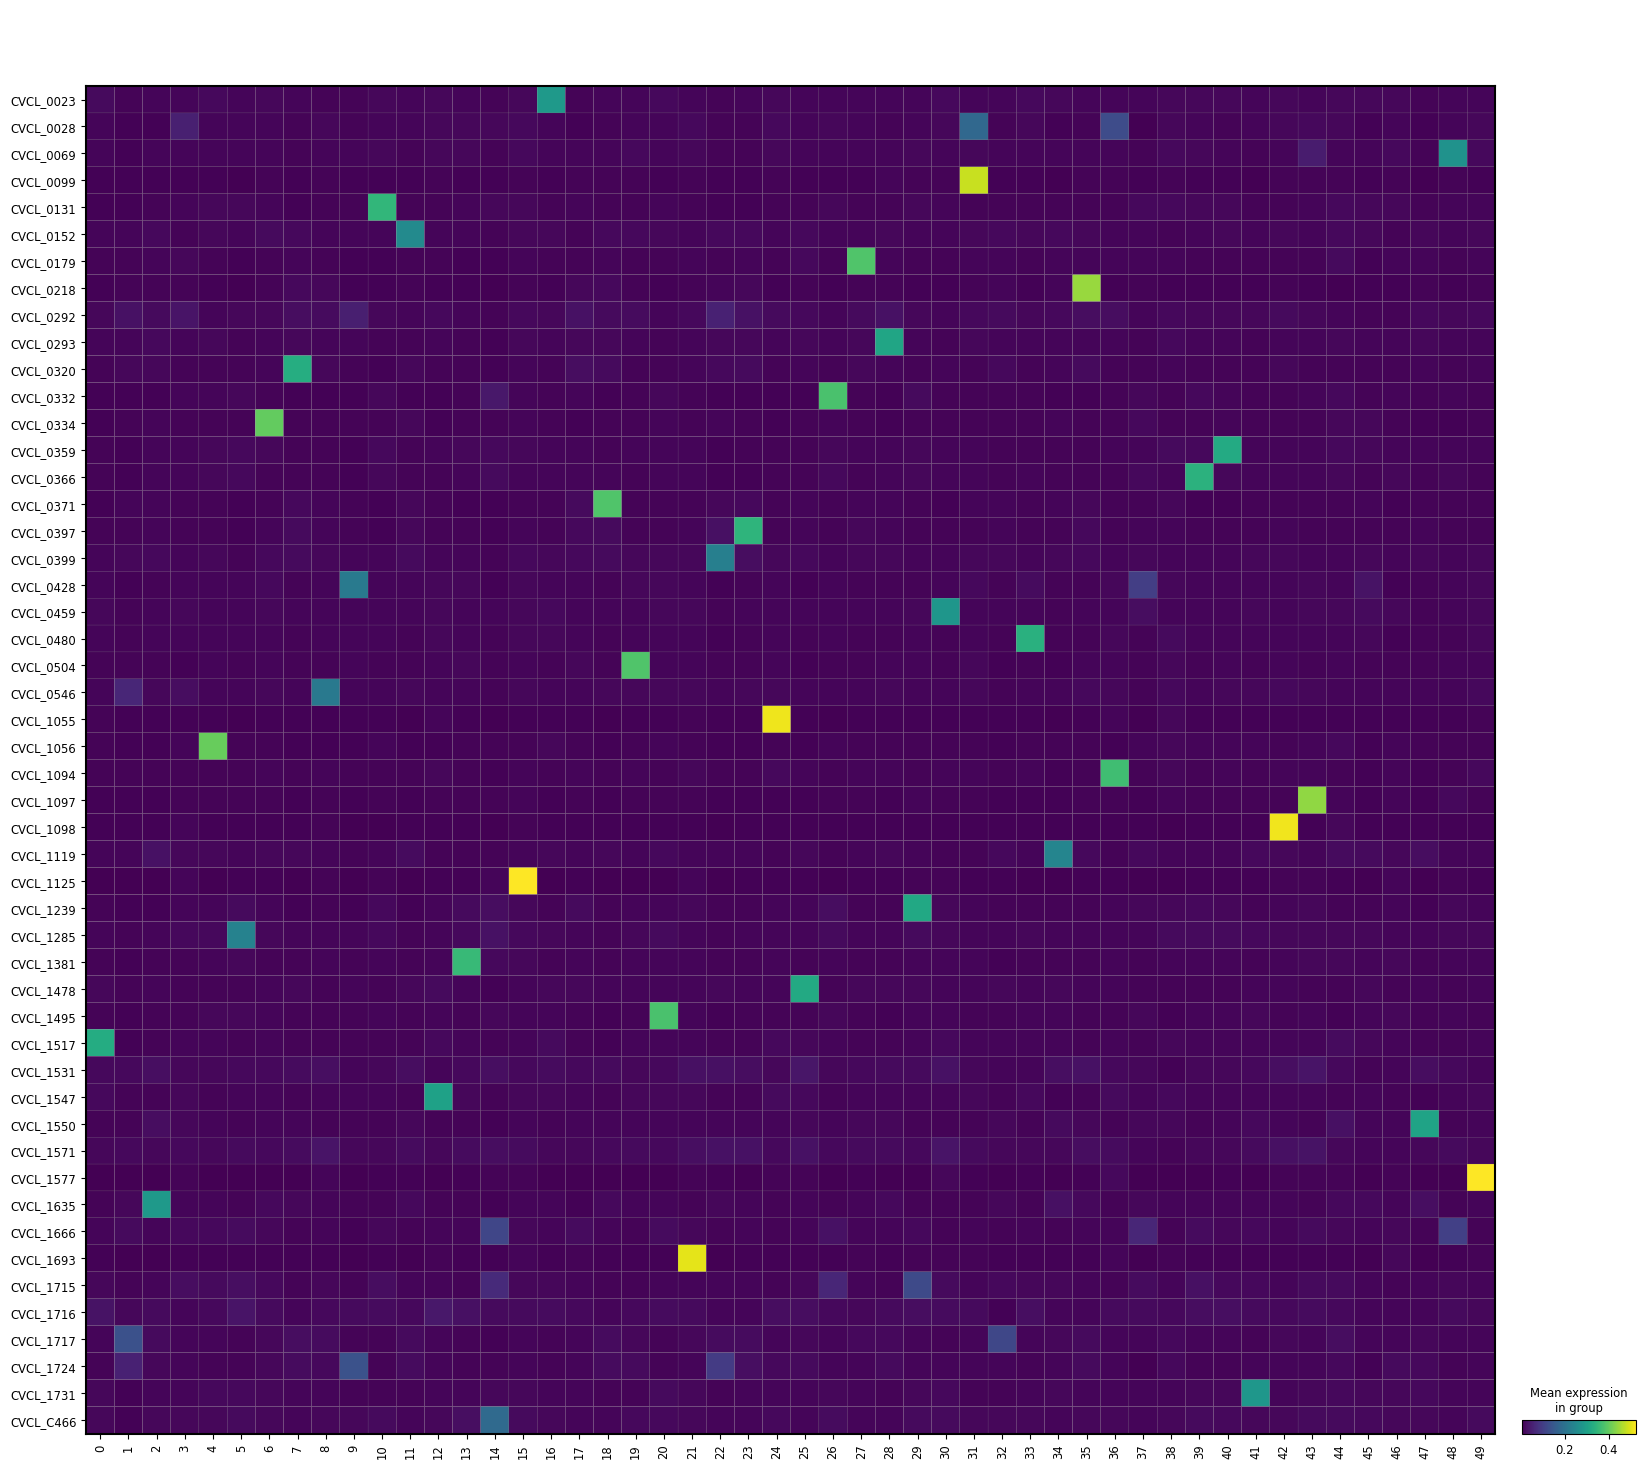

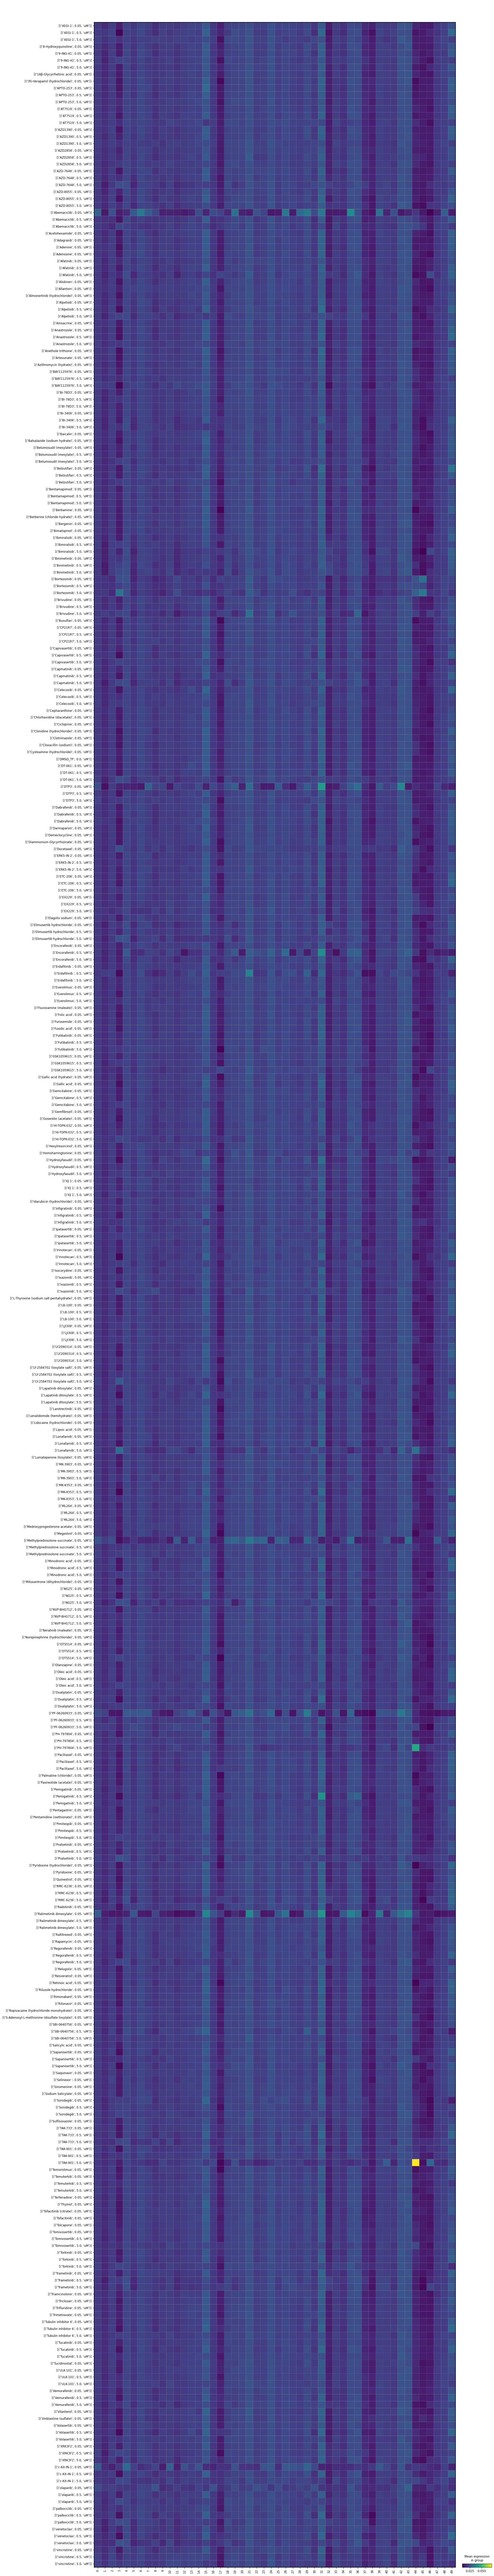

In [36]:
sc.pl.matrixplot(aggr_ldvae_ad, var_names = aggr_ldvae_ad.var_names, groupby='cell_line', layer= 'mean_LDVAE_embedding')
sc.pl.matrixplot(aggr_ldvae_ad, var_names = aggr_ldvae_ad.var_names, groupby='drugname_drugconc', layer= 'mean_LDVAE_embedding')